### Euler-Bernoulli model of beams

The Euler-Bernoulli beam theory describes the bending of slender beams under load, assuming small deformations and negligible shear effects. The vertical displacement $u_y(z)$ under a constant load $p_0$ solves:

$$
    \frac{\mathrm{d}^4 u_y(z)}{\mathrm{d}z^4} = \frac{p_0}{EI},
$$

where $E$ is Young’s modulus and $I = \iint_A y^2 \, \mathrm{d}x \mathrm{d}y$ is the second moment of area of the beam’s cross-section. Derived quantities include:

$$
    \theta(z) = -\frac{\mathrm{d} u_y(z)}{\mathrm{d}z} \quad \text{(Rotation angle)}
$$

$$
    M(z) = -EI \, \frac{\mathrm{d}^2 u_y(z)}{\mathrm{d}z^2} \quad \text{(Bending moment)}
$$

$$
    F(z) = -EI \, \frac{\mathrm{d}^3 u_y(z)}{\mathrm{d}z^3} \quad \text{(Shear force)}
$$

$$
    U = EI \int_0^L \left(\frac{\mathrm{d}^2 u_y(z)}{\mathrm{d}z^2}\right)^2 \mathrm{d}z \quad \text{(Elastic energy, } L = \text{beam length)}
$$

In [1]:
# Importing libraries
import sympy as smp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Defining global variables
z = smp.symbols("z", real = True, nonnegative = True)
a = smp.Function("a", real = True)(z)
E, L, I, p0 = smp.symbols("E L I p_0", real = True, positive = True, constant = True)

In [3]:
def solver(boundary = 'None'):

    # Equation to solve
    eq = smp.Eq(smp.Derivative(a, z, 4), p0 / (E * I))
    
    if boundary == 'fixed-fixed beam':
        ics = {
            a.subs(z, 0): 0,
            smp.diff(a, z, 1).subs(z, 0): 0,

            a.subs(z, L): 0,
            smp.diff(a, z, 1).subs(z, L): 0
            }
    
    if boundary == 'simply supported beam':
        ics = {
            a.subs(z, 0): 0,
            smp.diff(a, z, 2).subs(z, 0): 0,

            a.subs(z, L): 0,
            smp.diff(a, z, 2).subs(z, L): 0
            }
        
    if boundary == 'cantilever beam':
        ics = {
            a.subs(z, 0): 0,
            smp.diff(a, z, 1).subs(z, 0): 0,

            smp.diff(a, z, 2).subs(z, L): 0,
            smp.diff(a, z, 3).subs(z, L): 0
            }
        
    if boundary == 'propped-cantilever beam':
        ics = {
            a.subs(z, 0): 0,
            smp.diff(a, z, 1).subs(z, 0): 0,

            a.subs(z, L): 0,
            smp.diff(a, z, 2).subs(z, L): 0
            }
        
    if boundary == 'fixed-guided beam':
        ics = {
            a.subs(z, 0): 0,
            smp.diff(a, z, 1).subs(z, 0): 0,

            smp.diff(a, z, 1).subs(z, L): 0,
            smp.diff(a, z, 3).subs(z, L): 0
            }
    
    if boundary == 'pinned-guided beam':
        ics = {
            a.subs(z, 0): 0,
            smp.diff(a, z, 2).subs(z, 0): 0,
            
            smp.diff(a, z, 1).subs(z, L): 0,
            smp.diff(a, z, 3).subs(z, L): 0
            }
    
    if boundary == 'None':
        ics = None
    
    # Solving the equations with the choosen boundaries
    sol = smp.dsolve(eq, a, ics = ics).rhs.factor()

    # Computing the angle
    theta = - smp.diff(sol, z, 1).factor()

    # Computing the bending moment
    M = - E * I * smp.diff(sol, z, 2).factor()

    # Computing the shear force
    F = smp.diff(M, z, 1).factor()

    # Computing the elastic energy
    U = E * I * smp.integrate(smp.diff(sol, z, 2) ** 2, (z, 0, L)).factor()

    solution = (sol, theta, M, F, U)

    return solution

In [4]:
def plotter(solution, E_, L_, I_, p0_):

    z_ = np.linspace(0, L_, 1000)
    
    # Defining plot metadata
    plot_data = {
        0: {"title": "Vertical Displacement", "label": r"$u_y(z)$", "ylabel": "Displacement (m)", "color": "#1f77b4"},
        1: {"title": "Angle Rotation", "label": r"$\theta(z)$", "ylabel": "Angle (rad)", "color": "#ff7f0e"},
        2: {"title": "Bending Moment", "label": r"$M(z)$", "ylabel": "Moment (N·m)", "color": "#2ca02c"},
        3: {"title": "Shear Force", "label": r"$F_y(z)$", "ylabel": "Force (N)", "color": "#d62728"}
    }
    
    # Creating a 2x2 plot grid
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    axs = axs.flatten()
    
    # Setting global figure properties
    plt.rcParams.update({
        'font.size': 12,
        'font.family': 'serif',
        'mathtext.fontset': 'stix',
    })
    
    # Adding main figure title with parameters
    fig.suptitle(
        f"Beam Analysis: $E$ = {E_:.1e} Pa, $L$ = {L_} m, $I$ = {I_:.1e} m$^4$, $p_0$ = {p0_} N/m",
        fontsize=16,
        fontweight='bold',
        y=0.98
    )
    
    # Plotting each quantity in its own subplot
    for j in range(4):

        # Creating the numerical functions from symbolic expression
        f = smp.lambdify([z, E, L, I, p0], solution[j])
        y_vals = f(z_, E_, L_, I_, p0_)
        
        # Plotting with styling
        axs[j].plot(z_, y_vals, 
                   color=plot_data[j]["color"], 
                   linewidth=2.5,
                   label=plot_data[j]["label"])
        
        # Add dashed zero axes (x=0 and y=0)
        axs[j].axhline(0, color='black', linestyle='--', alpha=0.5, zorder=0)
        axs[j].axvline(0, color='black', linestyle='--', alpha=0.5, zorder=0)
        
        # Adding subplot decorations
        axs[j].set_title(plot_data[j]["title"], fontsize=14, pad=12)
        axs[j].set_xlabel("z (m)", fontsize=12, labelpad=10)
        axs[j].set_ylabel(plot_data[j]["ylabel"], fontsize=12, labelpad=10)
        axs[j].legend(loc='best', framealpha=0.9, shadow=True)
        
        # Adding grid and set spines
        axs[j].grid(True, linestyle='--', alpha=0.7)
        axs[j].spines[['right', 'top']].set_visible(False)
        
        # Setting scientific notation for large values
        if max(np.abs(y_vals)) > 1e4 or min(np.abs(y_vals)) < 1e-3:
            axs[j].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    
    # Adding footer with elastic energy
    elastic_energy = solution[4].subs({E: E_, L: L_, I: I_, p0: p0_})
    
    fig.text(
        0.5, 0.01, 
        f"Total Elastic Energy: U = {float(elastic_energy):.3e} J", 
        ha='center', 
        fontsize=12,
        bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round')
    )
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.96])

    return None

In [5]:
# General solution
sol = solver()

In [6]:
# General vertical displacement
sol[0]

(24*C1*E*I + 24*C2*E*I*z + 24*C3*E*I*z**2 + 24*C4*E*I*z**3 + p_0*z**4)/(24*E*I)

In [7]:
# General Angle
sol[1]

-(6*C2*E*I + 12*C3*E*I*z + 18*C4*E*I*z**2 + p_0*z**3)/(6*E*I)

In [8]:
# General bending moment
sol[2]

-2*C3*E*I - 6*C4*E*I*z - p_0*z**2/2

In [9]:
# General shear force
sol[3]

-6*C4*E*I - p_0*z

In [10]:
# General elastic energy
sol[4]

L*(240*C3**2*E**2*I**2 + 720*C3*C4*E**2*I**2*L + 40*C3*E*I*L**2*p_0 + 720*C4**2*E**2*I**2*L**2 + 90*C4*E*I*L**3*p_0 + 3*L**4*p_0**2)/(60*E*I)

In [11]:
# Setting constants
E_ = 30
L_ = 10
I_ = 15
p0_ = 20

In [12]:
# Solution for a fixed-fixed beam
sol = solver('fixed-fixed beam')

In [13]:
# Vertical displacement
sol[0]

p_0*z**2*(-L + z)**2/(24*E*I)

In [14]:
# Angle
sol[1]

-p_0*z*(-L + z)*(-L + 2*z)/(12*E*I)

In [15]:
# Bending moment
sol[2]

-p_0*(L**2 - 6*L*z + 6*z**2)/12

In [16]:
# Shear force
sol[3]

-p_0*(-L + 2*z)/2

In [17]:
# Elastic energy
sol[4]

L**5*p_0**2/(720*E*I)

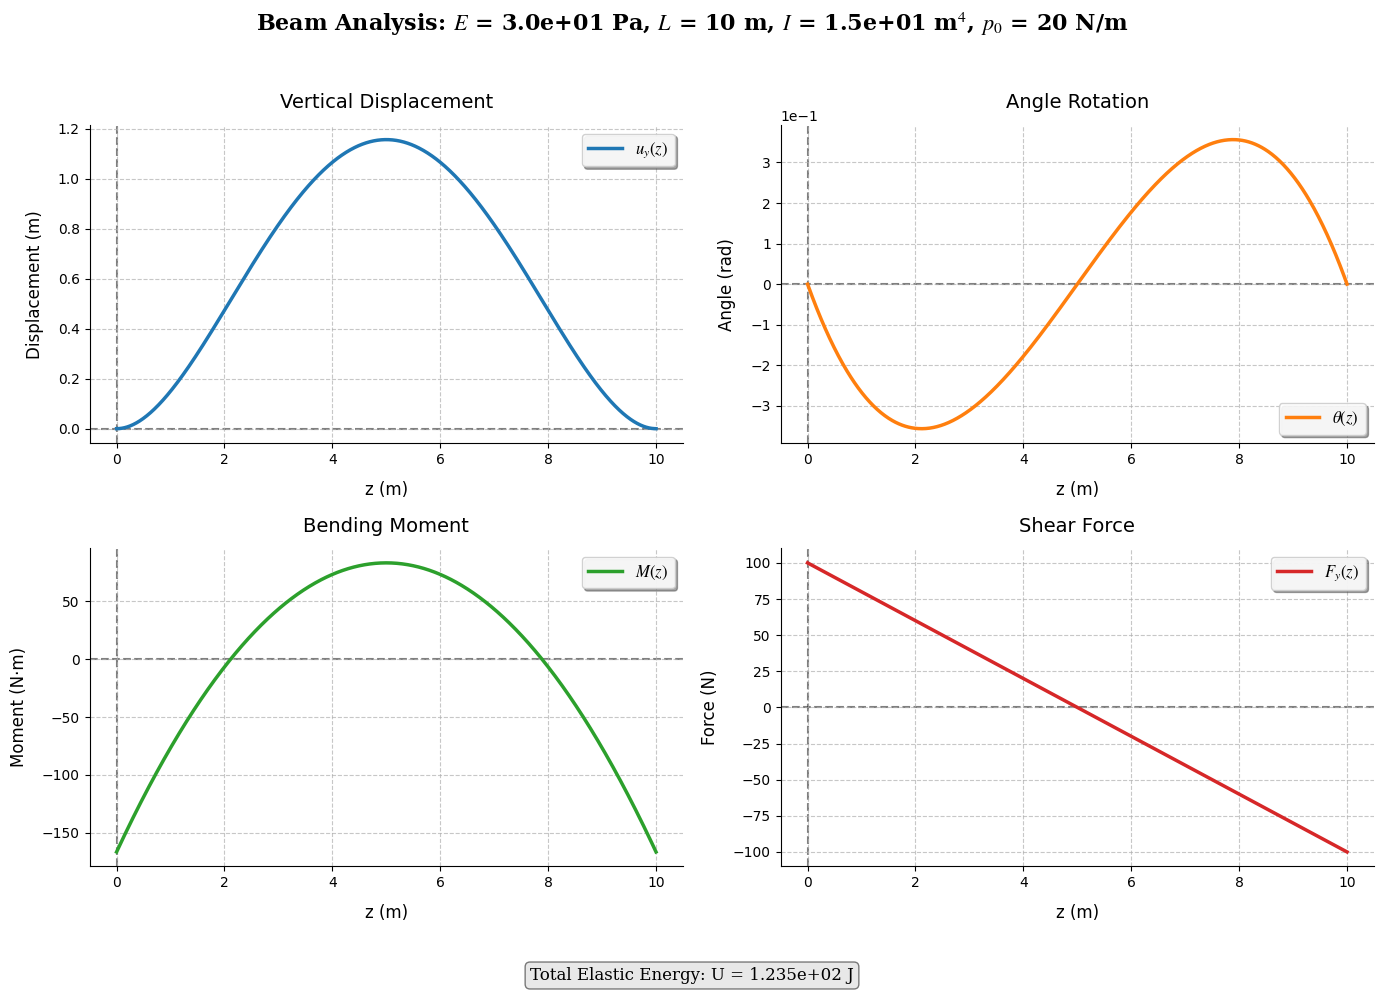

In [18]:
# Plot of the solution
plotter(sol, E_, L_, I_, p0_)

In [19]:
# Solution for a simply supported beam
sol = solver('simply supported beam')

In [20]:
# Vertical displacement
sol[0]

p_0*z*(-L + z)*(-L**2 - L*z + z**2)/(24*E*I)

In [21]:
# Angle
sol[1]

-p_0*(-L + 2*z)*(-L**2 - 2*L*z + 2*z**2)/(24*E*I)

In [22]:
# Bending moment
sol[2]

-p_0*z*(-L + z)/2

In [23]:
# Shear force
sol[3]

-p_0*(-L + 2*z)/2

In [24]:
# Elastic energy
sol[4]

L**5*p_0**2/(120*E*I)

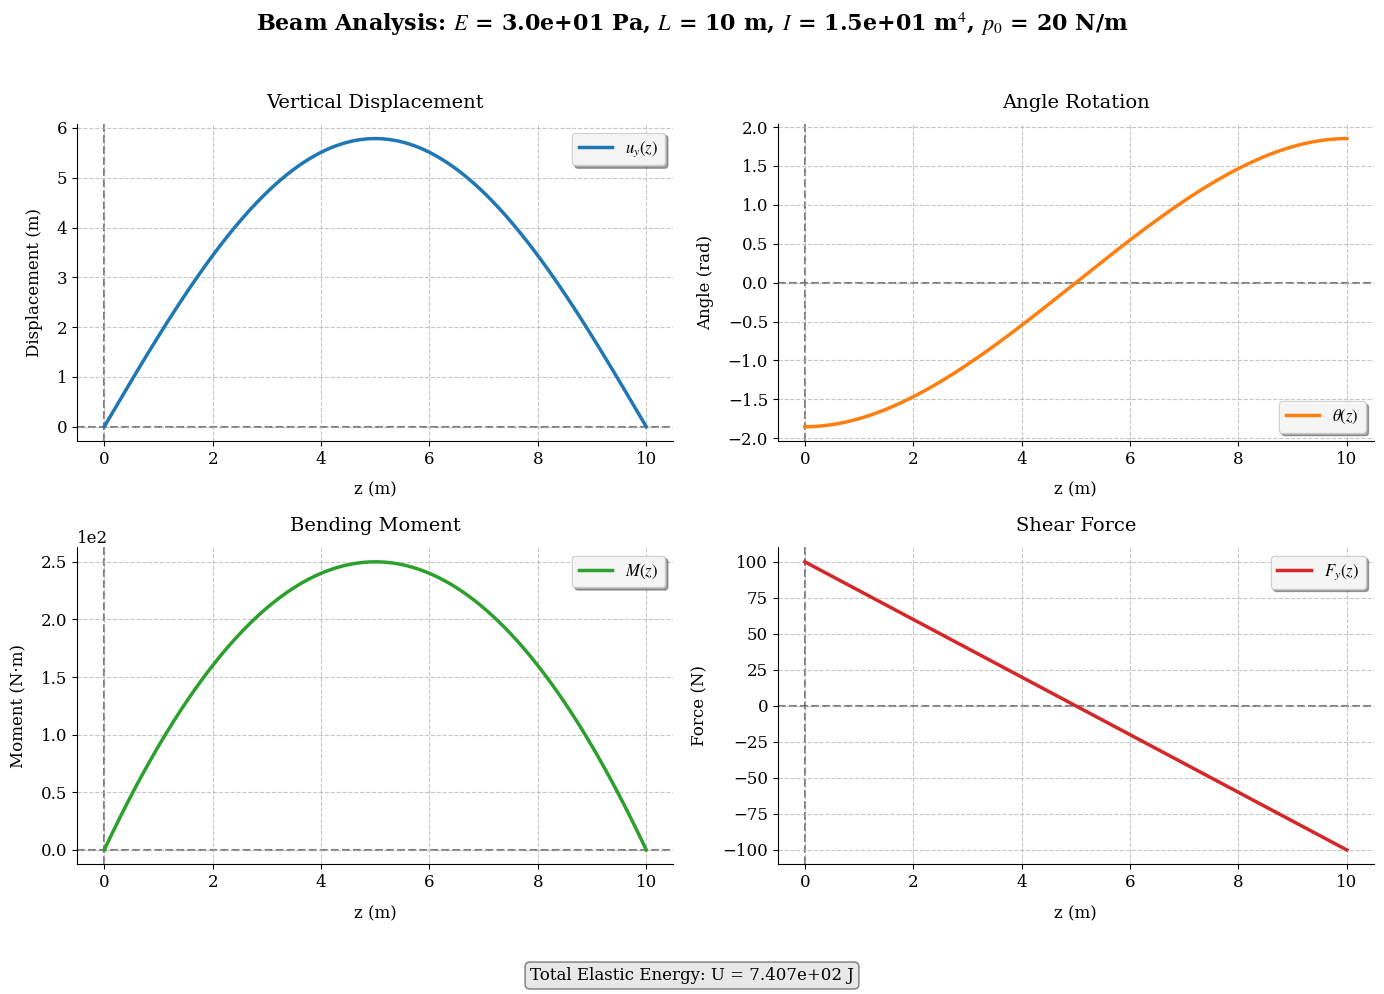

In [25]:
# Plot of the solution
plotter(sol, E_, L_, I_, p0_)

In [26]:
# Solution for a cantilever beam
sol = solver('cantilever beam')

In [27]:
# Vertical displacement
sol[0]

p_0*z**2*(6*L**2 - 4*L*z + z**2)/(24*E*I)

In [28]:
# Angle
sol[1]

-p_0*z*(3*L**2 - 3*L*z + z**2)/(6*E*I)

In [29]:
# Bending moment
sol[2]

-p_0*(-L + z)**2/2

In [30]:
# Shear force
sol[3]

-p_0*(-L + z)

In [31]:
# Elastic energy
sol[4]

L**5*p_0**2/(20*E*I)

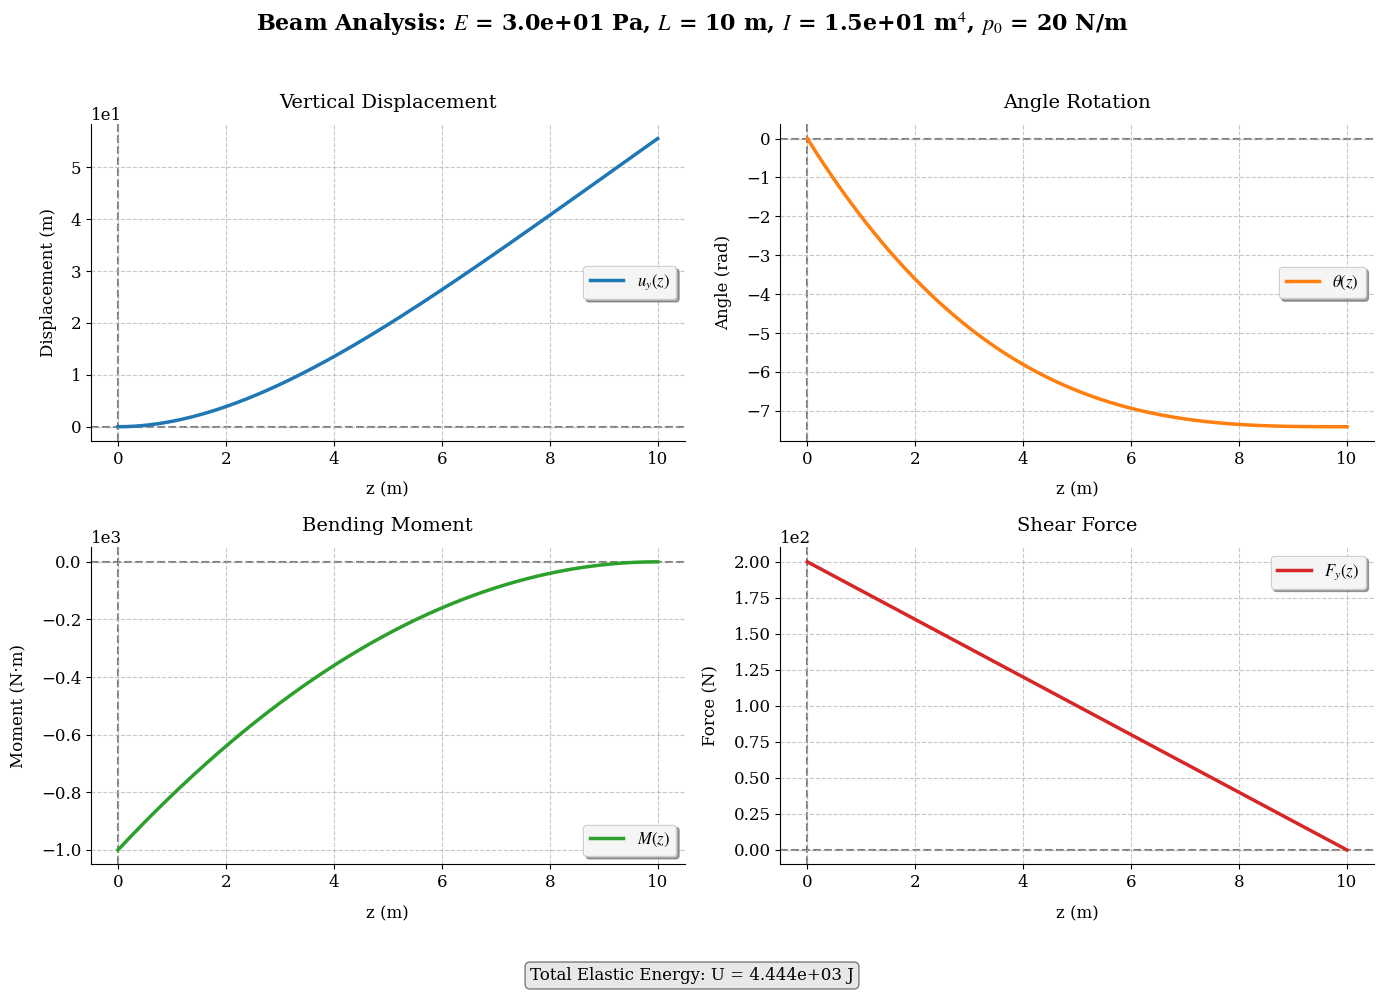

In [32]:
# Plot of the solution
plotter(sol, E_, L_, I_, p0_)

In [33]:
# Solution for a propped-cantilever beam
sol = solver('propped-cantilever beam')

In [34]:
# Vertical displacement
sol[0]

p_0*z**2*(-3*L + 2*z)*(-L + z)/(48*E*I)

In [35]:
# Angle
sol[1]

-p_0*z*(6*L**2 - 15*L*z + 8*z**2)/(48*E*I)

In [36]:
# Bending moment
sol[2]

-p_0*(-L + z)*(-L + 4*z)/8

In [37]:
# Shear force
sol[3]

-p_0*(-5*L + 8*z)/8

In [38]:
# Elastic energy
sol[4]

L**5*p_0**2/(320*E*I)

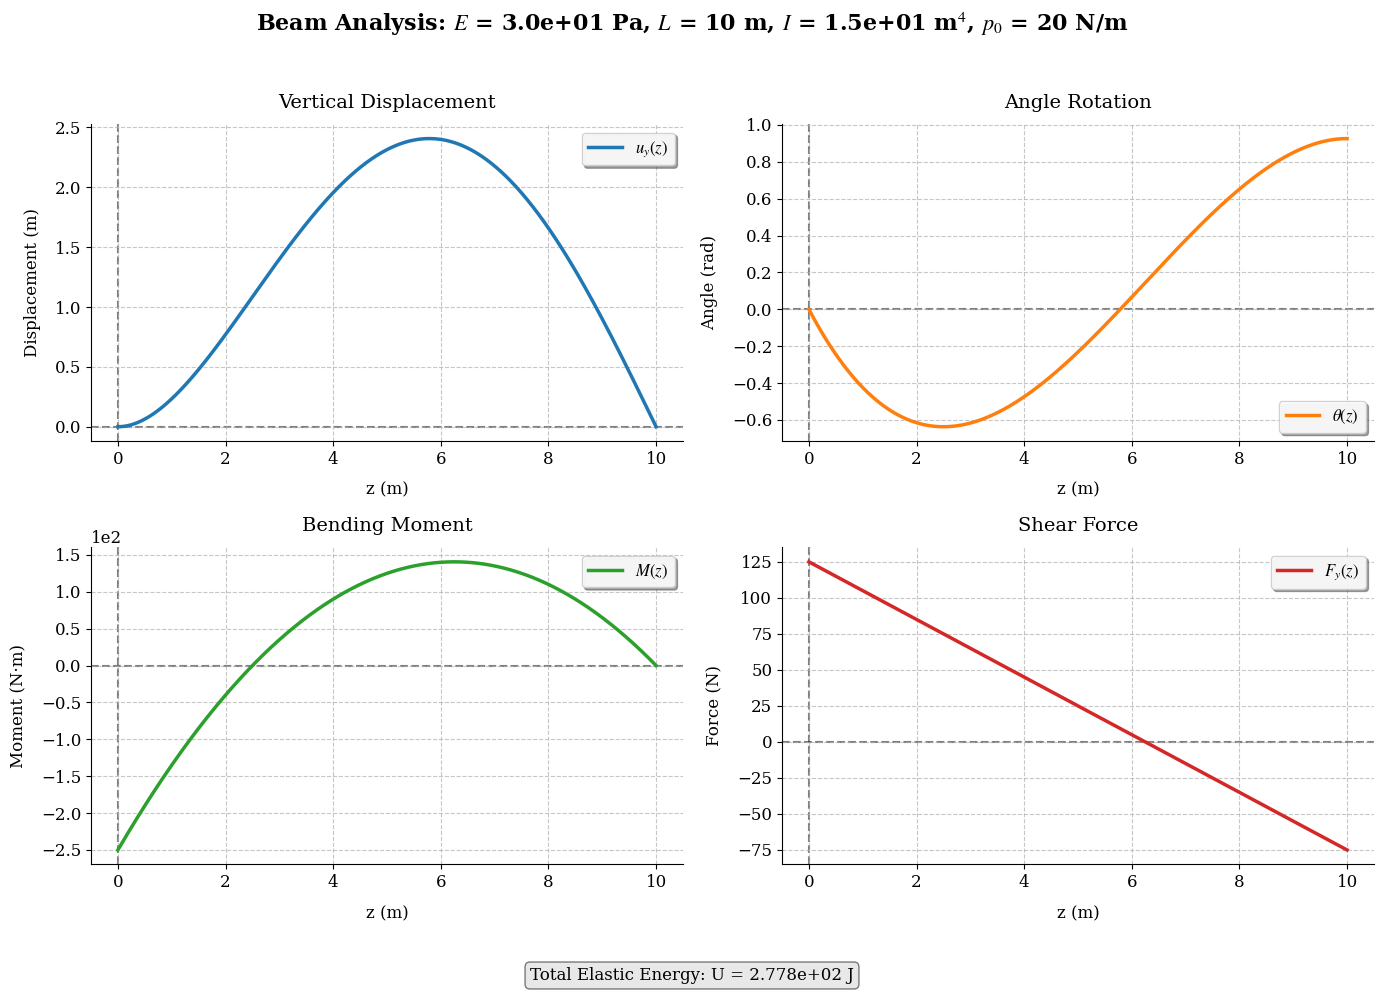

In [39]:
# Plot of the solution
plotter(sol, E_, L_, I_, p0_)

In [40]:
# Solution for a fixed-guided beam
sol = solver('fixed-guided beam')

In [41]:
# Vertical displacement
sol[0]

p_0*z**2*(-2*L + z)**2/(24*E*I)

In [42]:
# Angle
sol[1]

-p_0*z*(-2*L + z)*(-L + z)/(6*E*I)

In [43]:
# Bending moment
sol[2]

-p_0*(2*L**2 - 6*L*z + 3*z**2)/6

In [44]:
# Shear force
sol[3]

-p_0*(-L + z)

In [45]:
# Elastic energy
sol[4]

L**5*p_0**2/(45*E*I)

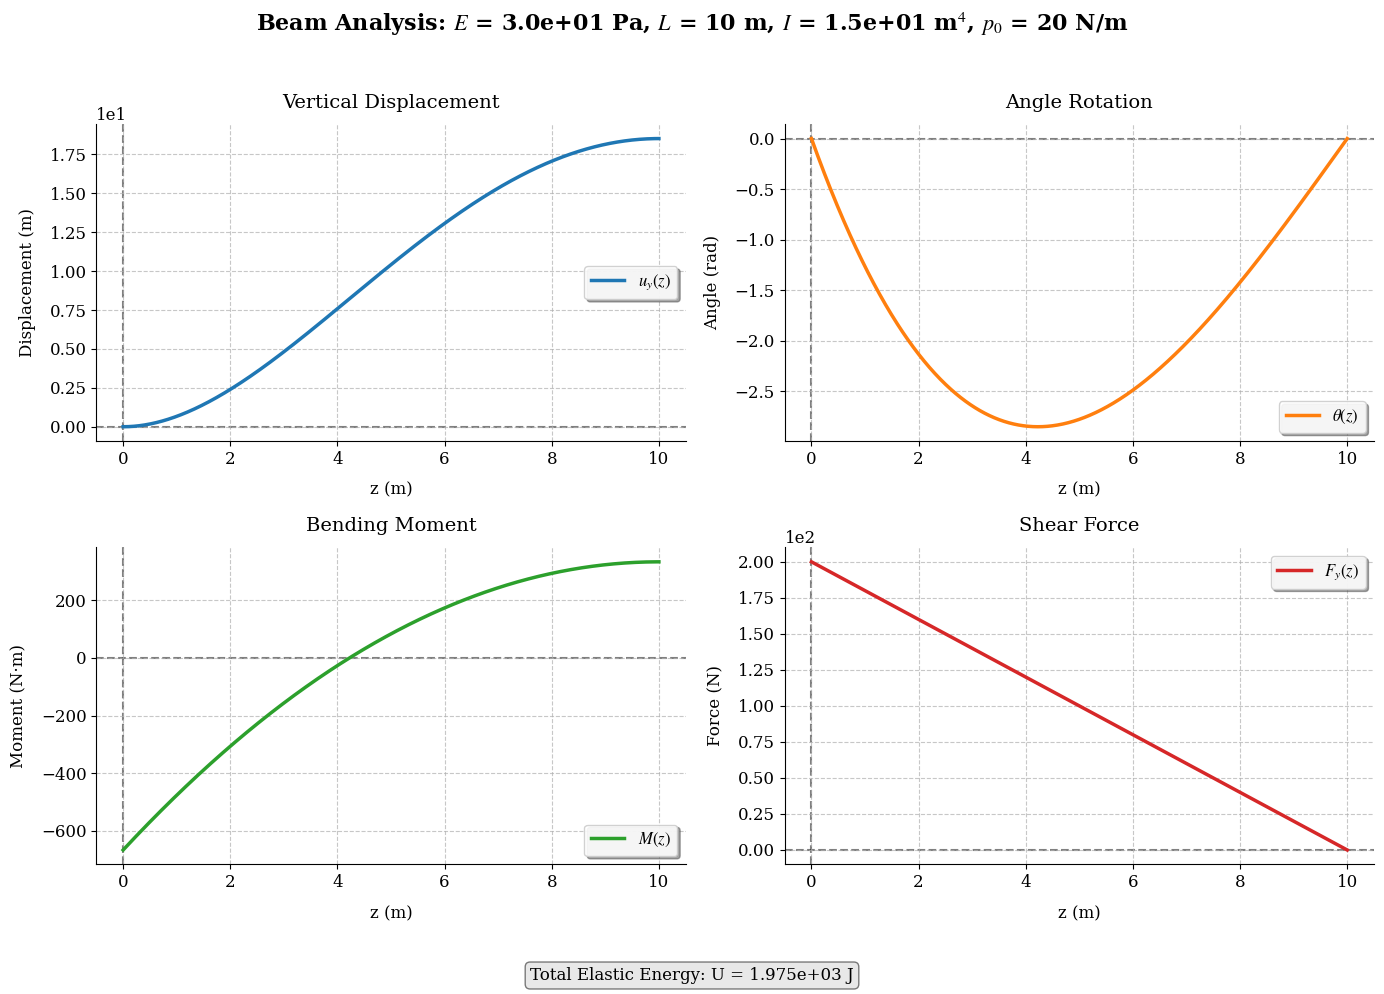

In [46]:
# Plot of the solution
plotter(sol, E_, L_, I_, p0_)

In [47]:
# Solution for a pinned-guided beam
sol = solver('pinned-guided beam')

In [48]:
# Vertical displacement
sol[0]

p_0*z*(-2*L + z)*(-4*L**2 - 2*L*z + z**2)/(24*E*I)

In [49]:
# Angle
sol[1]

-p_0*(-L + z)*(-2*L**2 - 2*L*z + z**2)/(6*E*I)

In [50]:
# Bending moment
sol[2]

-p_0*z*(-2*L + z)/2

In [51]:
# Shear force
sol[3]

-p_0*(-L + z)

In [52]:
# Elastic energy
sol[4]

2*L**5*p_0**2/(15*E*I)

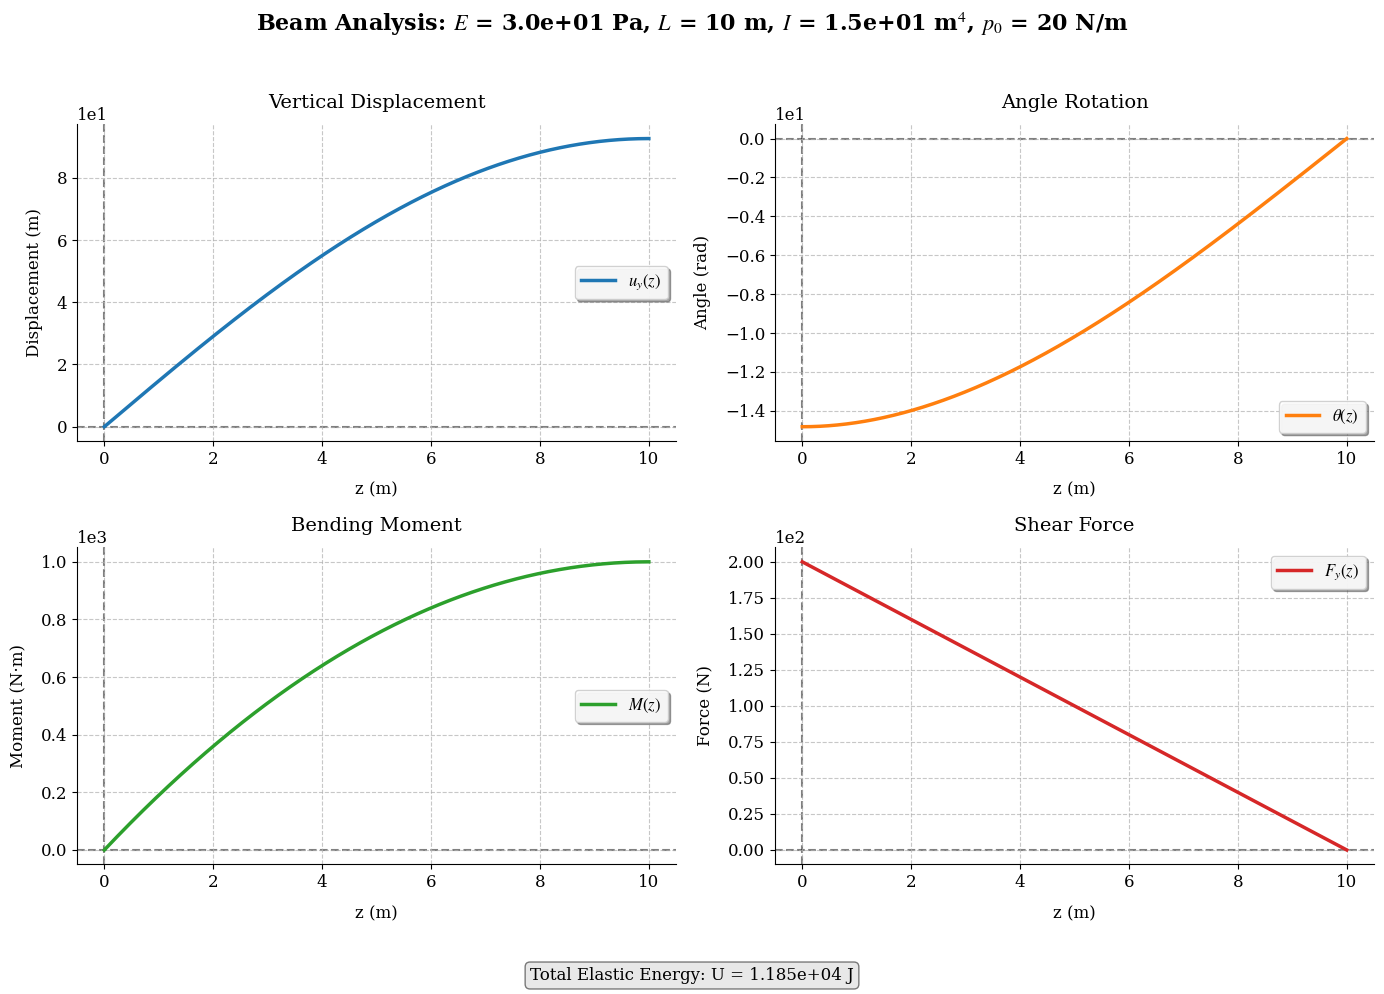

In [53]:
# Plot of the solution
plotter(sol, E_, L_, I_, p0_)